# Sistema simple de recomendación de películas con Python

¿Alguna vez te has preguntado cómo Netflix es capaz de adivinar casi a la perfección la serie o película que vas a ver? Te prometo que no es brujería, es tecnología. Lo que sucede detrás de las recomendaciones que ves cada día en diversas plataformas de streaming como Disney+, Max e inclusive Spotify, hay algoritmos que trabajan con millones de datos para ofrecerte contenido que podría gustarte. 

Uno de los algoritmos empleados en los sistemas de recomendación, se llama Filtrado Colaborativo (FC). ¿Te dejé igual? No te preocupes, vamos a desarrollar esta maraña para que veas cómo funciona esta tecnología, y lo mejor de todo, podrás desarrollar un sistema de recomendaciones simple con Python para que lo presumas con tus amigos.

## **Paso 1: Importar dependencias**

En este algoritmo se utilizarán los dataframes de Pandas que representaran nuestros datos, un dataframe no es nada mas que una estructura bidimensional de datos, similar a la que se observa en programas como Excel, donde se tienen columnas que representan características y filas que representan ítems.

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## **Paso 2: Cargar los datos**

Se trabajará con el conjunto de datos `ml-latest-small.zip` extraído de la plataforma de MovieLens, de todos estos datos, la información más relevante para este ejemplo está ubicada en los ficheros:

- ratings.csv (incluye las reseñas de cada usuario a una película en específico con su marca de tiempo)
- movies.csv (incluye información sobre cada película)

Los datos se cargaron a un DataFrame de Pandas

In [73]:
ratings_df = pd.read_csv('data/ratings.csv')

In [74]:
movies_df = pd.read_csv('data/movies.csv')

## **Paso 3: Análisis exploratorio de datos**

Se aplicó un análisis de estadística descriptiva para comprender la información que existe en el dataset y así poder encontrar información relevante que sirva en la construcción del modelo

### **Análisis de valoraciones**

Como primer paso se realizó un análisis de las valoraciones que cada usuario ha hecho sobre una película, para determinar si se cuenta con amplitud en las valoraciones, es decir, que el conjunto de datos muestre una distribución normal y no una con tendencia al lado positivo o negativo, ya que eso puede impactar en los resultados del modelo.

In [75]:
#  Número de valoraciones en el dataset
ratingsLength = len(ratings_df)
# Número de películas únicas en el dataset 
moviesLength = ratings_df['movieId'].nunique()
# Número de usuarios únicos en el dataset
usersLength = ratings_df['userId'].nunique()

print(f'Número de valoraciones en el dataset: {ratingsLength}')
print(f'Número de películas únicas en el dataset: {moviesLength}')
print(f'Número de usuarios únicos en el dataset: {usersLength}')

# Promedio de valoraciones por usuario y por película (redondeado a 2 decimales)
print(f'Promedio de valoraciones por usuario: {round(ratingsLength/usersLength, 2)}')
print(f'Promedio de valoraciones por película: {round(ratingsLength/moviesLength, 2)}')

Número de valoraciones en el dataset: 100836
Número de películas únicas en el dataset: 9724
Número de usuarios únicos en el dataset: 610
Promedio de valoraciones por usuario: 165.3
Promedio de valoraciones por película: 10.37


#### **¿Cómo está la distribución de las valoraciones?**

Se generó una gráfica de barras para conocer la distribución de valoraciones de las películas

C:\Users\quiqu\AppData\Local\Temp\ipykernel_21432\508794909.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x= 'rating', data=ratings_df, palette='RdYlGn')


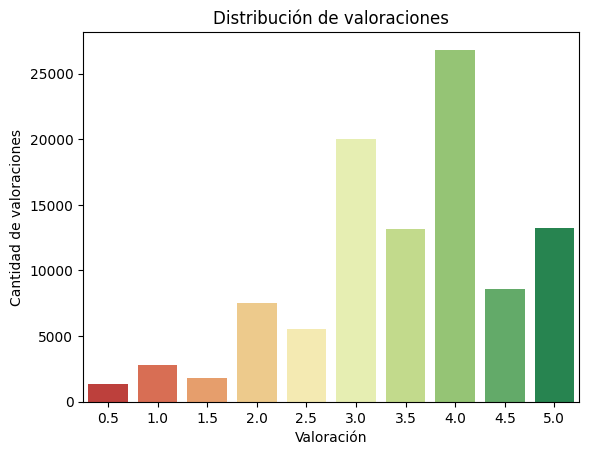

In [76]:
sns.countplot(x= 'rating', data=ratings_df, palette='RdYlGn')
plt.title('Distribución de valoraciones')
plt.xlabel('Valoración')
plt.ylabel('Cantidad de valoraciones')
plt.show()

#### **¿Cuál es el promedio de las valoraciones de forma global y por usuario?**

In [77]:
# Promedio de valoración de forma global (redondeado a 1 decimal)
print(f'Promedio de valoración de forma global: {round(ratings_df["rating"].mean(), 1)} estrellas')

# Promedio de valoración por usuario (redondeado a 1 decimal)
userRatings = ratings_df.groupby('userId')['rating'].mean()
print(f'Promedio de valoración por usuario: {round(userRatings.mean(), 1)} estrellas')

Promedio de valoración de forma global: 3.5 estrellas
Promedio de valoración por usuario: 3.7 estrellas


#### **¿Qué películas tienen más reseñas?**

In [78]:
# Películas con más reseñas
moviesRatings = ratings_df.merge(movies_df, on='movieId')
moviesRatings['title'].value_counts()[0:10]

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: count, dtype: int64

Las películas con más reseñas son:
- Forest Gump (1994)
- Shawshank Redemption (1994)
- Pulp Fiction (1994)
- Silence of the Lambs, The (1991) 

#### **¿Qué película tiene la mejor y la peor calificación promedio?**

In [79]:
# Promedio de valoración de todas las películas
meanRatings = ratings_df.groupby('movieId')[['rating']].mean()


In [80]:
# Película con menor valoración promedio
worstMovie = meanRatings['rating'].idxmin()
movies_df[movies_df['movieId'] == worstMovie]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


`Gypsy (1962)` es la película con peor calificación

In [81]:
# Película con mayor valoración promedio
bestMovie = meanRatings['rating'].idxmax()
movies_df[movies_df['movieId'] == bestMovie]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


`Lamerica (1994)` es la película con mayor calificación

#### **¿Cuántas valoraciones tiene Lamerica?**

In [82]:
# Valoraciones de Lamerica
ratings_df[ratings_df['movieId'] == bestMovie]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


En el resultado anterior, existe un problema, ya que aparentemente Lamerica es la película mejor calificada, pero solo cuenta con dos valoraciones. Si una película tiene una calificación muy alta pero solo ha sido evaluada por dos personas, no podemos estar seguros de que esa calificación sea representativa. Es posible que esas dos personas tengan gustos muy específicos que no reflejan la opinión general.

En un algoritmo de filtrado colaborativo, que se basa en las calificaciones de los usuarios para recomendar películas, esto puede ser un problema. Si el algoritmo ve que "Lamerica" tiene una calificación alta, podría recomendarla a muchas personas, pero si esas dos calificaciones no son representativas, la recomendación podría no ser buena.

El promedio bayesiano es una técnica que ayuda a mitigar este problema. En lugar de confiar únicamente en las calificaciones dadas, el promedio bayesiano combina estas calificaciones con una calificación promedio general de todas las películas. Esto se hace para evitar que películas con muy pocas calificaciones tengan un impacto desproporcionado.

In [83]:
# Películas con más reseñas y mejor valoración promedio
movieStats = ratings_df.groupby('movieId')['rating'].agg(['count', 'mean'])
movieStats.head()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [84]:
C = movieStats['count'].mean()
m = movieStats['mean'].mean()

print(f"Número promedio de valoraciones por película: {C:.2f}")
print(f"Promedio de valoración por película: {m:.2f}")

def bayesianAverage(ratings):
    bayesianAvg = (C * m + ratings.sum()) / (C + ratings.count())
    return round(bayesianAvg, 3)

Número promedio de valoraciones por película: 10.37
Promedio de valoración por película: 3.26


In [85]:
# Valoración bayesiana de Lamerica
lamerica = pd.Series([5,5])
print(f"Valoración bayesiana de Lamerica: {bayesianAverage(lamerica)}")

Valoración bayesiana de Lamerica: 3.543


Procedemos a aplicar el promedio bayesiano a todas las películas del conjunto de datos

In [86]:
bayesianAverageRatings = ratings_df.groupby('movieId')['rating'].agg(bayesianAverage).reset_index()
bayesianAverageRatings.columns = ['movieId', 'bayesian_avg']
movieStats = movieStats.merge(bayesianAverageRatings, on='movieId')
movieStats = movieStats.merge(movies_df[['movieId', 'title']])
movieStats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,"Usual Suspects, The (1995)"


Usando el promedio bayesiano, se observa que ahora la película más calificada es `Shawshank Redemption`.

In [87]:
movieStats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267,Godzilla (1998)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)


Por otro lado, la película peor calificada ahora es `Speed 2: Cruise Control` 

### **Análisis de géneros de películas**

Adicional al análisis de las valoraciones, se realizó el mismo procedimiento con los géneros de las películas para hallar conocimiento en los datos y determinar que géneros aparecen más en el conjunto de datos, para ello, primero se tiene que realizar una limpieza, ya que en el conjunto de datos los géneros están divididos por el carácter `|`, lo que no facilitaría el análisis en esta etapa.

In [88]:
movies_df['genres'] = movies_df['genres'].str.split('|')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


#### **¿Cuántos géneros existen?**

In [89]:
from collections import Counter

genreCounter = Counter(genre for genres in movies_df['genres'] for genre in genres)

print(f'Existen {len(genreCounter)} géneros diferentes en el dataset')
genreCounter

Existen 20 géneros diferentes en el dataset


Counter({'Drama': 4361,
         'Comedy': 3756,
         'Thriller': 1894,
         'Action': 1828,
         'Romance': 1596,
         'Adventure': 1263,
         'Crime': 1199,
         'Sci-Fi': 980,
         'Horror': 978,
         'Fantasy': 779,
         'Children': 664,
         'Animation': 611,
         'Mystery': 573,
         'Documentary': 440,
         'War': 382,
         'Musical': 334,
         'Western': 167,
         'IMAX': 158,
         'Film-Noir': 87,
         '(no genres listed)': 34})

#### **¿Cuáles son los 5 géneros más comunes?**

In [90]:
print('Los 5 géneros más comunes son: \n', genreCounter.most_common(5))

Los 5 géneros más comunes son: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


C:\Users\quiqu\AppData\Local\Temp\ipykernel_21432\1158378022.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='genre', y='count', data=genreCounter_df.sort_values(by='count', ascending=False), palette='Set1')


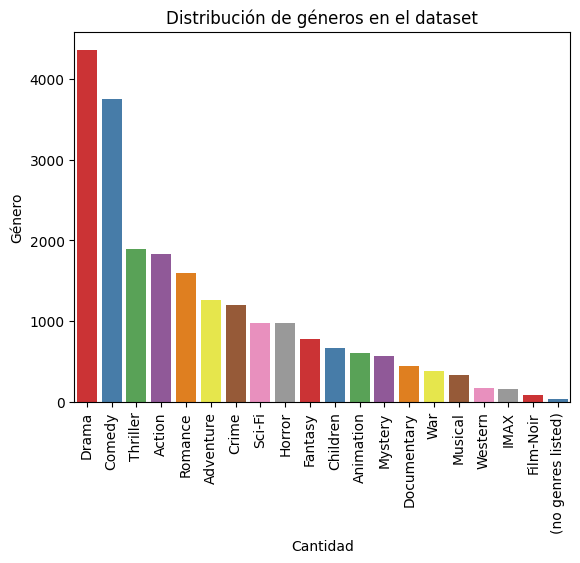

In [91]:
genreCounter_df = pd.DataFrame([genreCounter]).T.reset_index()
genreCounter_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=genreCounter_df.sort_values(by='count', ascending=False), palette='Set1')
plt.title('Distribución de géneros en el dataset')
plt.xticks(rotation=90)
plt.xlabel('Cantidad')
plt.ylabel('Género')

plt.show()

## **Paso 4: Pre-procesamiento de datos**

En este punto, se utilizará la técnica de filtrado colaborativo para generar recomendaciones a los usuarios. La premisa de esta técnica es que a usuarios con gustos similares les gustan cosas similares.

Como primer paso, se deben transformar los datos, de manera de que en lugar de tener dos columnas con información dividida, se tenga una matriz que combine toda la información, de manera que las columnas representen películas y las filas usuarios, enfocándonos en las valoraciones como datos de las celdas.

Para el proceso anterior, se tendrán que generar diccionarios para mapear los valores relevantes de columna a matriz:

- **userMapper:** Mapea un id de usuario a un índice de fila en la matriz.
- **movieMapper:** Mapea un id de película a un índice de columna en la matriz.
- **userInverseMapper:** Realiza el proceso contrario, de un índice de fila retorna el id de usuario.
- **movieInverseMapper:** De igual forma, toma un índice de columna para devolver el id de la película.

Con los diccionarios anteriores, se tendrá la relación de que un usuario/película corresponde a una fila/columna de la matriz.

In [92]:
from scipy.sparse import csr_matrix

#  Crea una matriz de valoraciones a partir de un DataFrame
def createMatrix(df):
    """
    Args:
        df (pd.DataFrame): DataFrame con las valoraciones de los usuarios (userId, movieId, rating)

    Returns:
        matrix: Matriz de valoraciones
        userMapper: Mapeo de userId a índice entero
        movieMapper: Mapeo de movieId a índice entero
        userInverseMapper: Mapeo inverso de userId a índice entero
        movieInverseMapper: Mapeo inverso de movieId a índice entero
    """

    # Número de usuarios y películas únicas
    M = df ['userId'].nunique()
    N = df['movieId'].nunique()

    # Crear un mapeo de userId y movieId a un índice entero
    userMapper = dict(zip(np.unique(df['userId']), list(range(M))))
    movieMapper = dict(zip(np.unique(df['movieId']), list(range(N))))

    # Mapper inverso
    userInverseMapper = dict(zip(list(range(M)), np.unique(df['userId'])))
    movieInverseMapper = dict(zip(list(range(N)), np.unique(df['movieId'])))

    userIndex = [userMapper[i] for i in df['userId']]
    movieIndex = [movieMapper[i] for i in df['movieId']]

    # Crear la matriz de valoraciones
    matrix = csr_matrix((df['rating'], (userIndex, movieIndex)), shape=(M, N))

    # Retornar la matriz y los mappers
    return matrix, userMapper, movieMapper, userInverseMapper, movieInverseMapper

In [93]:
matrix, userMapper, movieMapper, userInverseMapper, movieInverseMapper = createMatrix(ratings_df)
matrix.shape

(610, 9724)

El tamaño de la matriz es de 610 usuarios x 9724 películas

#### **Evaluación de escasez de datos**

La escasez de datos puede impactar en la veracidad del algoritmo, para ello, se calculó la escasez en los datos dividiendo el número de elementos almacenados con el total de elementos

In [94]:
# Número total de elementos en la matriz
totalElements = matrix.shape[0] * matrix.shape[1]

# Número de elementos no nulos en la matriz
nonZeroElements = matrix.count_nonzero()

# Porcentaje de escasez
sparsity = (nonZeroElements / totalElements) * 100

print(f'El porcentaje de escasez de datos es: {sparsity:.2f}%')

El porcentaje de escasez de datos es: 1.70%


El siguiente paso es comprobar si existiría un problema de arranque frio, esto se produce cuando en la matriz hay nuevos usuarios o películas, y por ende, no hay valoraciones. Como primer paso se comprobarán las valoraciones por usuario.

In [95]:
# Valoraciones por usuario
ratingsPerUser = matrix.getnnz(axis=1)
len(ratingsPerUser)

610

In [96]:
print(f'El usuario más activo ha realizado {ratingsPerUser.max()} valoraciones')
print(f'El usuario menos activo ha realizado {ratingsPerUser.min()} valoraciones')

El usuario más activo ha realizado 2698 valoraciones
El usuario menos activo ha realizado 20 valoraciones


Posteriormente, se calcularán las valoraciones por película

In [97]:
# Valoraciones por película
ratingsPerMovie = matrix.getnnz(axis=0)
len(ratingsPerMovie)

9724

In [98]:
print(f'La película más valorada tiene {ratingsPerMovie.max()} valoraciones')
print(f'La película menos valorada tiene {ratingsPerMovie.min()} valoraciones')

La película más valorada tiene 329 valoraciones
La película menos valorada tiene 1 valoraciones


De manera gráfica:

C:\Users\quiqu\AppData\Local\Temp\ipykernel_21432\1830526771.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ratingsPerUser, color='r', shade=True)
C:\Users\quiqu\AppData\Local\Temp\ipykernel_21432\1830526771.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ratingsPerMovie, color='b', shade=True)


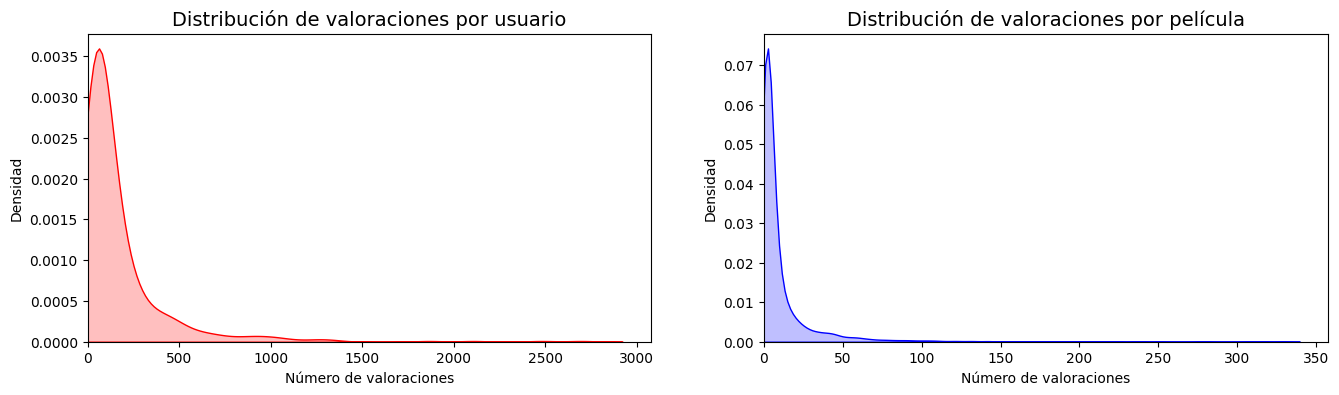

In [99]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
sns.kdeplot(ratingsPerUser, color='r', shade=True)
plt.xlim(0)
plt.title('Distribución de valoraciones por usuario', fontsize=14)
plt.xlabel('Número de valoraciones')
plt.ylabel('Densidad')
plt.subplot(1, 2, 2)
sns.kdeplot(ratingsPerMovie, color='b', shade=True)
plt.xlim(0)
plt.title('Distribución de valoraciones por película', fontsize=14)
plt.xlabel('Número de valoraciones')
plt.ylabel('Densidad')

plt.show()

## **Paso 5: Recomendación de películas usando KNN**

En este punto se utilizó la técnica de KNN (k-Nearest Neighbors) para encontrar *k* películas que tienen una interacción de usuario similar para una película *i*

In [113]:
from sklearn.neighbors import NearestNeighbors

# Función para encontrar películas similares
def findSimilarMovies(movieId, matrix, movieMapper, movieInverseMapper, k=5, metric='cosine'):
    """
    Args:
        movieId (int): movieId de la película de la que se quiere encontrar las similares
        matrix (csr_matrix): Matriz de valoraciones
        movieMapper (dict): Mapeo de movieId a índice entero
        movieInverseMapper (dict): Mapeo de índice entero a id de película
        k (int): Número de películas similares a encontrar
        metric (str): Medida de similitud a utilizar

    Returns:
        list: Películas similares
    """

    matrix = matrix.T
    kneighbors = []

    movieIndex = movieMapper[movieId]
    movieVector = matrix[movieIndex]
    if isinstance(movieVector, (np.ndarray)):
        movieVector = movieVector.reshape(1, -1)
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm='brute', metric=metric)
    kNN.fit(matrix)
    neighbor = kNN.kneighbors(movieVector, return_distance=False) 

    for i in range(0, k):
        n = neighbor.item(i)
        kneighbors.append(movieInverseMapper[n])
    kneighbors.pop(0)

    return kneighbors

Comprobamos el funcionamiento del modelo

In [119]:
# Mapeo de movieId a título de película
movieTitles = dict(zip(movies_df['movieId'], movies_df['title']))

# Película de la que se quiere encontrar las similares
movieId = 122892

# Llamado a la función para encontrar películas similares
similarMovies = findSimilarMovies(movieId, matrix, movieMapper, movieInverseMapper, k=20)

# Obtenemos el título de la película
movieTitle = movieTitles[movieId]

# Imprimimos las películas similares
print(f'Películas similares a {movieTitle}:')
# Recorre el arreglo de películas similares
for movieId in similarMovies:
    # Busca el título de la película en el diccionario
    print(movieTitles[movieId])

Películas similares a Avengers: Age of Ultron (2015):
Captain America: The Winter Soldier (2014)
Thor: The Dark World (2013)
Captain America: The First Avenger (2011)
X-Men: Days of Future Past (2014)
Thor (2011)
Avengers, The (2012)
Guardians of the Galaxy (2014)
Iron Man 2 (2010)
Iron Man 3 (2013)
Captain America: Civil War (2016)
Deadpool (2016)
Ant-Man (2015)
X-Men: First Class (2011)
The Lego Movie (2014)
Kingsman: The Secret Service (2015)
Star Trek Into Darkness (2013)
Man of Steel (2013)
Doctor Strange (2016)
X-Men Origins: Wolverine (2009)
